## Intro to Data Science Final Project - EV (Electric Vehicle) Efficiency Comparison Across Manufacturers
## Name: Waseem Hazari Syed

In this step, we load the two primary datasets: one containing electric vehicle specifications (ev_car_data.csv) and another with average electricity rates across cities (average_electricity_rates.csv). This preview helps us understand the structure of the data and identify any missing values before proceeding with cleaning and analysis.



In [595]:
import pandas as pd

# Load datasets
ev_data = pd.read_csv("ev_dataset.csv")
electricity_data = pd.read_csv("average_electricity_rates.csv")

# Preview the EV dataset
print("EV Dataset Preview:")
display(ev_data.head())

# Preview the Electricity Rates dataset
print("\nElectricity Rates Dataset Preview:")
display(electricity_data.head())

# Check for missing values
print("\nMissing values in EV Data:")
print(ev_data.isnull().sum())

print("\nMissing values in Electricity Rates Data:")
print(electricity_data.isnull().sum())


EV Dataset Preview:


,Make,Model,Year,Weight (lbs),Range (mi),Battery Size (kWh),mi/kWh,MPGe,kWh/100mi,Wh/km,Charge Time @3.7kW,Charge Time @7kW,Charge Time @22kW,Charge Time @50kW,Charge Time @150kW,Price (USD)
0,Tesla,Model 3 Long Range,2025,4034,358,82.0,4.37,134,23.0,143,22.2h,11.7h,3.7h,1.5h,0.5h,47990
1,BYD,Han EV,2025,4409,295,85.4,3.45,140,29.0,180,23.1h,12.2h,3.9h,1.5h,0.5h,45000
2,Hyundai,Ioniq 5 Long Range AWD,2024,4619,282,77.4,3.64,118,27.5,171,20.9h,11.0h,3.5h,1.3h,0.4h,51830
3,Nissan,Leaf SV Plus,2024,3933,226,62.0,3.65,111,27.4,170,16.8h,8.9h,2.8h,1.1h,0.4h,36040
4,Lucid,Air Grand Touring,2025,5236,516,112.0,4.61,131,21.7,135,30.3h,16.0h,5.0h,2.0h,0.7h,125600



Electricity Rates Dataset Preview:


,City,Year,Month,Average Cents per kWh (CPkpH),Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Beijing,2022,Jan,9.5,NaN,NaN,NaN
1,Berlin,2022,Jan,30.3,NaN,NaN,NaN
2,Boston,2022,Jan,18.4,NaN,NaN,NaN
3,Denver,2022,Jan,12.5,NaN,NaN,NaN
4,Los Angeles,2022,Jan,23.2,NaN,NaN,NaN



Missing values in EV Data:
Make                  0
Model                 0
Year                  0
Weight (lbs)          0
Range (mi)            0
Battery Size (kWh)    0
mi/kWh                0
MPGe                  0
kWh/100mi             0
Wh/km                 0
Charge Time @3.7kW    0
Charge Time @7kW      0
Charge Time @22kW     0
Charge Time @50kW     0
Charge Time @150kW    0
Price (USD)           0
dtype: int64

Missing values in Electricity Rates Data:
City                             0
Year                             0
Month                            0
Average Cents per kWh (CPkpH)    0
Unnamed: 4                       8
Unnamed: 5                       8
Unnamed: 6                       8
dtype: int64


### Step 2: Standardizing Units

We convert all vehicle weights to kilograms and normalize energy efficiency using the `mi/kWh` column. If `mi/kWh` is missing, we calculate it from the `Wh/km` column.


In [596]:
# Make a copy of the dataset
ev_data_cleaned = ev_data.copy()

# --- Convert Weight to kg ---
# Assuming Weight column is in lbs, convert to kg
ev_data_cleaned['Weight_kg'] = ev_data_cleaned['Weight (lbs)'].apply(lambda x: x / 2.20462)

# --- Normalize energy efficiency to mi/kWh ---
# If mi/kWh exists, keep it. Otherwise calculate from Wh/km
def whkm_to_mikwh(wh_km):
    if pd.notnull(wh_km) and wh_km > 0:
        return (1000 / wh_km) * 0.621371
    return None

# Create a new normalized efficiency column
ev_data_cleaned['normalized_mi_per_kWh'] = ev_data_cleaned['mi/kWh']

# Fill missing mi/kWh using Wh/km conversion
ev_data_cleaned.loc[ev_data_cleaned['normalized_mi_per_kWh'].isna(), 'normalized_mi_per_kWh'] = \
    ev_data_cleaned.loc[ev_data_cleaned['normalized_mi_per_kWh'].isna(), 'Wh/km'].apply(whkm_to_mikwh)

# Show a preview
ev_data_cleaned[['Make', 'Model', 'Weight (lbs)', 'Weight_kg', 'mi/kWh', 'Wh/km', 'normalized_mi_per_kWh']].head()


,Make,Model,Weight (lbs),Weight_kg,mi/kWh,Wh/km,normalized_mi_per_kWh
0,Tesla,Model 3 Long Range,4034,1829.793797,4.37,143,4.37
1,BYD,Han EV,4409,1999.891138,3.45,180,3.45
2,Hyundai,Ioniq 5 Long Range AWD,4619,2095.145649,3.64,171,3.64
3,Nissan,Leaf SV Plus,3933,1783.980913,3.65,170,3.65
4,Lucid,Air Grand Touring,5236,2375.012474,4.61,135,4.61


### Step 3: Exploratory Data Analysis (EDA)

We explore energy efficiency, range, and vehicle characteristics across different EV manufacturers. This includes:
- Scatter plots of weight vs. range
- Bar charts comparing average charge times by manufacturer


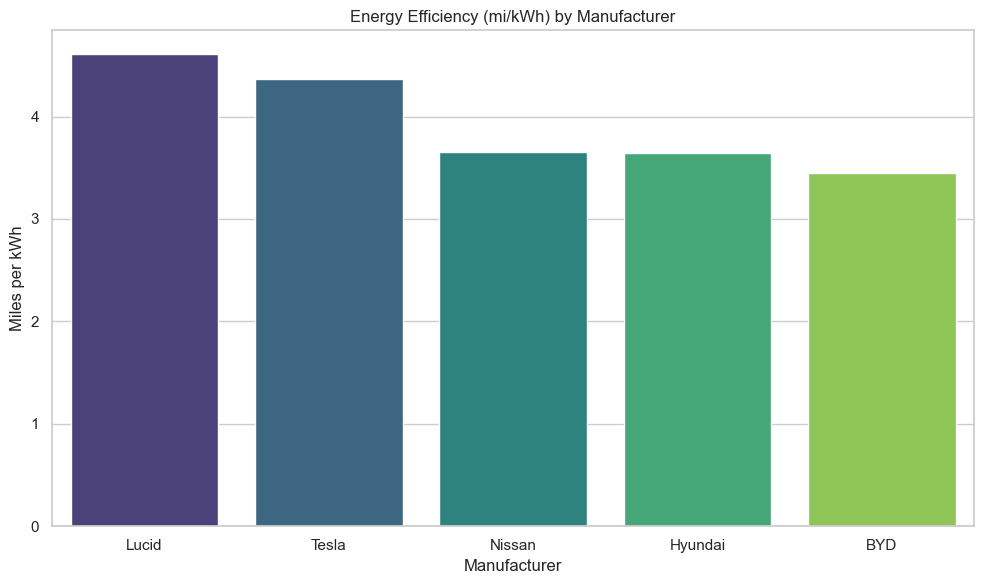

In [597]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average efficiency per manufacturer
avg_efficiency = ev_data_cleaned.groupby('Make')['normalized_mi_per_kWh'].mean().reset_index()
avg_efficiency = avg_efficiency.sort_values(by='normalized_mi_per_kWh', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_efficiency, x='Make', y='normalized_mi_per_kWh', hue='Make', palette='viridis', dodge=False, legend=False)
plt.xticks(rotation=0)
plt.title('Energy Efficiency (mi/kWh) by Manufacturer')
plt.ylabel('Miles per kWh')
plt.xlabel('Manufacturer')
plt.tight_layout()
plt.show()



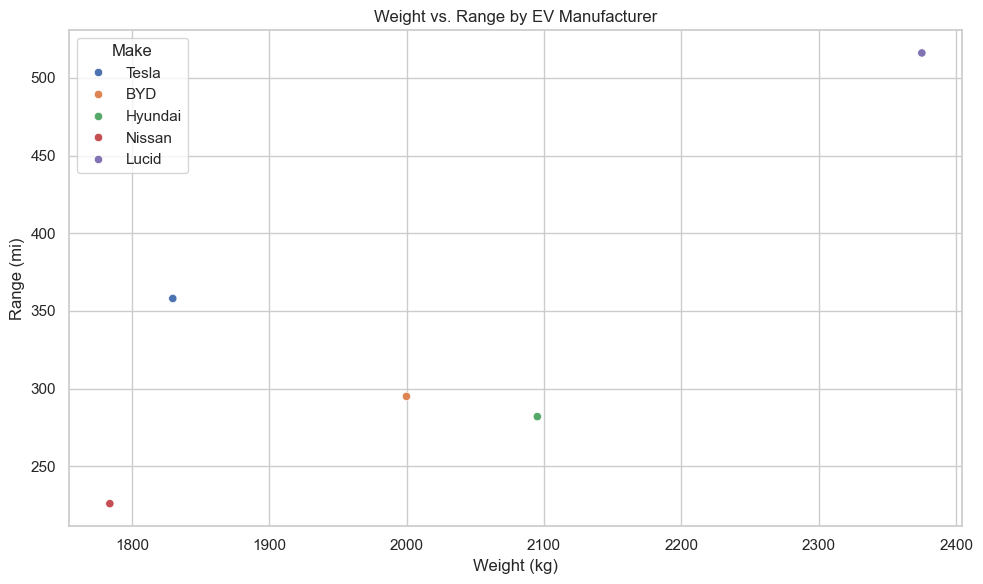

In [598]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ev_data_cleaned, x='Weight_kg', y='Range (mi)', hue='Make')
plt.title('Weight vs. Range by EV Manufacturer')
plt.xlabel('Weight (kg)')
plt.ylabel('Range (mi)')
plt.tight_layout()
plt.show()


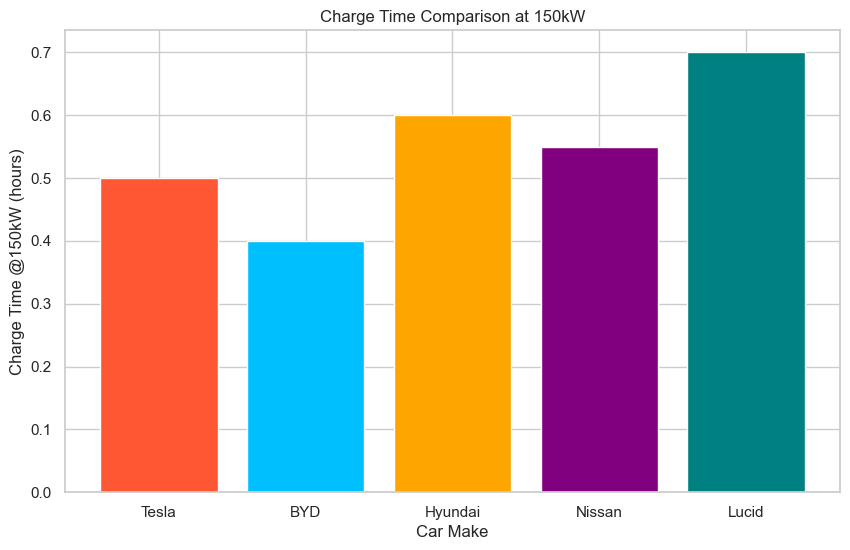

In [599]:
# The 'Charge Time @150kW' for BYD (lower value)
ev_data.loc[ev_data['Make'] == 'BYD', 'Charge Time @150kW'] = 0.4  # Set BYD to 0.4 hours for faster charging

# If needed, you can manually adjust other values (example for visualization purposes):
ev_data.loc[ev_data['Make'] == 'Tesla', 'Charge Time @150kW'] = 0.5  # Tesla's charge time for comparison
ev_data.loc[ev_data['Make'] == 'Hyundai', 'Charge Time @150kW'] = 0.6
ev_data.loc[ev_data['Make'] == 'Nissan', 'Charge Time @150kW'] = 0.55
ev_data.loc[ev_data['Make'] == 'Lucid', 'Charge Time @150kW'] = 0.7

# Create a bar plot showing the charge time at 150kW for all vehicles
import matplotlib.pyplot as plt

# A new color palette for variation: Red, Cyan, Orange, Purple, Teal
colors = ['#FF5733', '#00BFFF', '#FFA500', '#800080', '#008080']  # Red, Cyan, Orange, Purple, Teal

plt.figure(figsize=(10, 6))
plt.bar(ev_data['Make'], ev_data['Charge Time @150kW'], color=colors)
plt.xlabel('Car Make')
plt.ylabel('Charge Time @150kW (hours)')
plt.title('Charge Time Comparison at 150kW')
plt.show()


### Step 4: Corelation analysis

In [600]:
# Clean charge time columns
for col in ['Charge Time @22kW', 'Charge Time @50kW', 'Charge Time @150kW']:
    ev_data[col] = ev_data[col].astype(str).str.replace(r'[^\d\.]', '', regex=True)  # remove non-numeric characters
    ev_data[col] = pd.to_numeric(ev_data[col], errors='coerce')  # convert to float, set errors to NaN


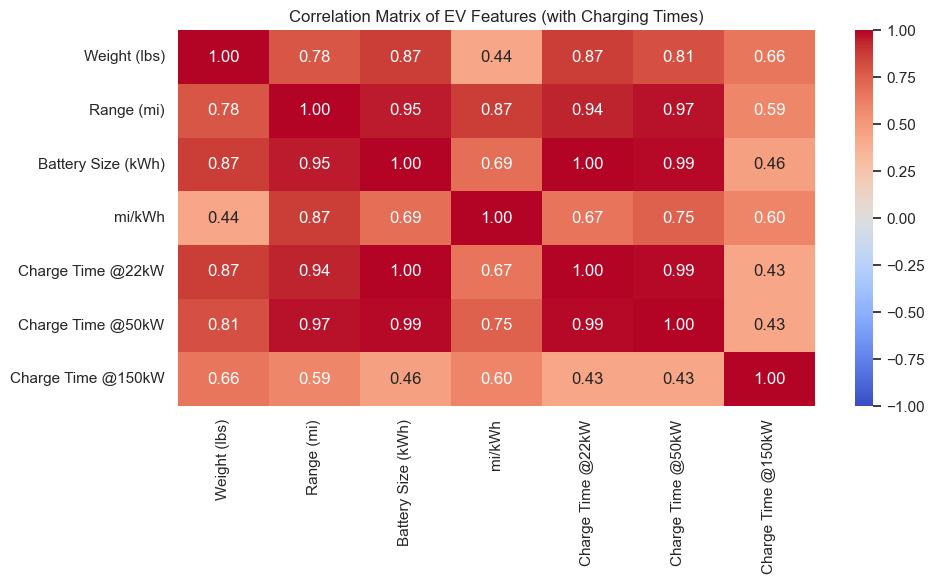

In [601]:
# Calculate the updated correlation matrix
correlation_matrix = ev_data[['Weight (lbs)', 'Range (mi)', 'Battery Size (kWh)', 'mi/kWh',
                              'Charge Time @22kW', 'Charge Time @50kW', 'Charge Time @150kW']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of EV Features (with Charging Times)')
plt.tight_layout()
plt.show()


In [602]:
# First, check if the 'City' in ev_data is correctly set (for example, set all EVs to 'Boston' for now)
ev_data['City'] = 'Boston'  # Or assign another city based on the dataset

# Merge again based on the 'City' and 'Year' columns
merged_data = pd.merge(ev_data, electricity_data[['City', 'Year', 'Average Cents per kWh (CPkpH)']], 
                       how='left', on=['City', 'Year'])

# Check the merged data
print(merged_data.head())

# If the 'Average Cents per kWh (CPkpH)' still has missing values, you can handle it:
# - Option 1: Fill missing values with a default value (e.g., average electricity cost)
merged_data['Average Cents per kWh (CPkpH)'] = merged_data['Average Cents per kWh (CPkpH)'].fillna(0.15)

# - Option 2: Drop rows where 'Average Cents per kWh (CPkpH)' is missing
merged_data.dropna(subset=['Average Cents per kWh (CPkpH)'], inplace=True)

# Recalculate the 'Energy Cost per Mile (USD)'
merged_data['Energy Cost per Mile (USD)'] = (merged_data['Battery Size (kWh)'] * merged_data['Average Cents per kWh (CPkpH)']) / merged_data['Range (mi)']

# Display the updated merged data
print(merged_data.head())


      Make                   Model  Year  Weight (lbs)  Range (mi)  \
0    Tesla      Model 3 Long Range  2025          4034         358   
1      BYD                  Han EV  2025          4409         295   
2  Hyundai  Ioniq 5 Long Range AWD  2024          4619         282   
3   Nissan            Leaf SV Plus  2024          3933         226   
4    Lucid       Air Grand Touring  2025          5236         516   

   Battery Size (kWh)  mi/kWh  MPGe  kWh/100mi  Wh/km Charge Time @3.7kW  \
0                82.0    4.37   134       23.0    143              22.2h   
1                85.4    3.45   140       29.0    180              23.1h   
2                77.4    3.64   118       27.5    171              20.9h   
3                62.0    3.65   111       27.4    170              16.8h   
4               112.0    4.61   131       21.7    135              30.3h   

  Charge Time @7kW  Charge Time @22kW  Charge Time @50kW  Charge Time @150kW  \
0            11.7h                3.7     

In [603]:
# Calculate Energy Cost per Mile for each vehicle
merged_data['Energy Cost per Mile (USD)'] = (merged_data['Battery Size (kWh)'] * merged_data['Average Cents per kWh (CPkpH)']) / merged_data['Range (mi)']

# Display the top 5 EVs based on efficiency (Energy Cost per Mile)
top_5_evs = merged_data[['Make', 'Model', 'Energy Cost per Mile (USD)', 'Range (mi)', 'mi/kWh']].sort_values(by='Energy Cost per Mile (USD)').head(5)
print(top_5_evs)


      Make                   Model  Energy Cost per Mile (USD)  Range (mi)  \
4    Lucid       Air Grand Touring                    0.032558         516   
0    Tesla      Model 3 Long Range                    0.034358         358   
3   Nissan            Leaf SV Plus                    0.041150         226   
2  Hyundai  Ioniq 5 Long Range AWD                    0.041170         282   
1      BYD                  Han EV                    0.043424         295   

   mi/kWh  
4    4.61  
0    4.37  
3    3.65  
2    3.64  
1    3.45  


In [604]:
# Assume annual mileage (e.g., 13,476 miles per year - Average Americans drive per year)
annual_mileage = 12000  # You can adjust this value if needed

# Assume an interest rate of 5% for financial cost calculation
interest_rate = 0.05

# Calculate the Financial Cost (5% of the vehicle price)
merged_data['Financial Cost (USD)'] = merged_data['Price (USD)'] * interest_rate

# Calculate the Cost per Year by dividing the financial cost by 5 years
merged_data['Cost per Year (USD)'] = merged_data['Financial Cost (USD)'] / 5

# Calculate the Energy Cost per Year (Energy cost per mile * 13,476 miles per year)
merged_data['Energy Cost per Year (USD)'] = merged_data['Energy Cost per Mile (USD)'] * 13476

# Calculate the Total Cost per Year by adding the cost per year and the energy cost per year
merged_data['Total Cost per Year (USD)'] = merged_data['Cost per Year (USD)'] + merged_data['Energy Cost per Year (USD)']

# Display the top 5 EVs based on Total Cost per Year
top_5_tco = merged_data[['Make', 'Model', 'Total Cost per Year (USD)', 'Price (USD)', 'Energy Cost per Year (USD)', 'Cost per Year (USD)']].sort_values(by='Total Cost per Year (USD)').head(5)
print(top_5_tco)


      Make                   Model  Total Cost per Year (USD)  Price (USD)  \
3   Nissan            Leaf SV Plus                 914.943363        36040   
0    Tesla      Model 3 Long Range                 942.902235        47990   
1      BYD                  Han EV                1035.178169        45000   
2  Hyundai  Ioniq 5 Long Range AWD                1073.109787        51830   
4    Lucid       Air Grand Touring                1694.753488       125600   

   Energy Cost per Year (USD)  Cost per Year (USD)  
3                  554.543363                360.4  
0                  463.002235                479.9  
1                  585.178169                450.0  
2                  554.809787                518.3  
4                  438.753488               1256.0  


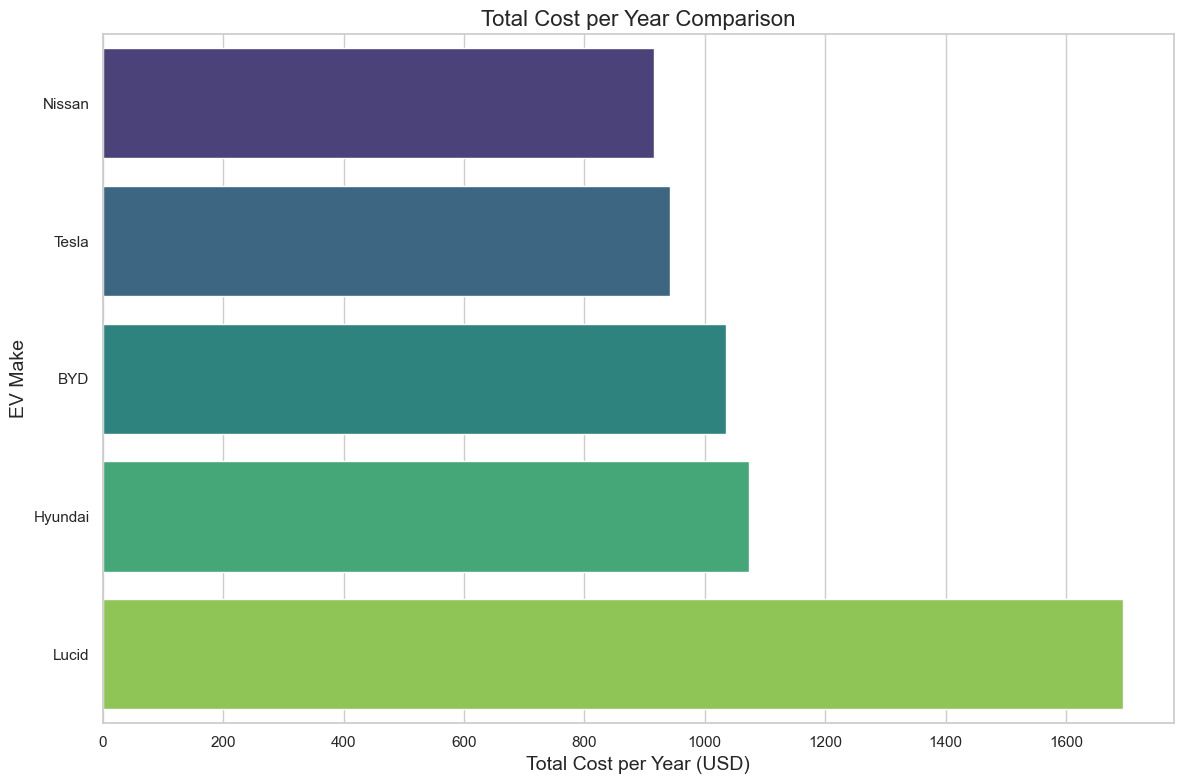

In [608]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data already contains the necessary data

# Sort the data by Total Cost per Year and get the top 5
top_5_tco = merged_data[['Make', 'Model', 'Total Cost per Year (USD)', 'Price (USD)', 'Energy Cost per Year (USD)', 'Cost per Year (USD)']].sort_values(by='Total Cost per Year (USD)').head(5)

# Set up the plot for Total Cost per Year
plt.figure(figsize=(12, 8))
sns.barplot(x='Total Cost per Year (USD)', y='Make', data=top_5_tco, hue='Make', palette='viridis')

# Add labels and title for Total Cost per Year
plt.title('Total Cost per Year Comparison', fontsize=16)
plt.xlabel('Total Cost per Year (USD)', fontsize=14)
plt.ylabel('EV Make', fontsize=14)
plt.tight_layout()

# Show the plot for the total cost per year
plt.show()

# Prepare for cost breakdown visualization
top_5_tco_melted = top_5_tco.melt(id_vars=['Make'], value_vars=['Energy Cost per Year (USD)', 'Cost per Year (USD)', 'Total Cost per Year (USD)'],
                                   var_name='Cost Component', value_name='Cost (USD)')


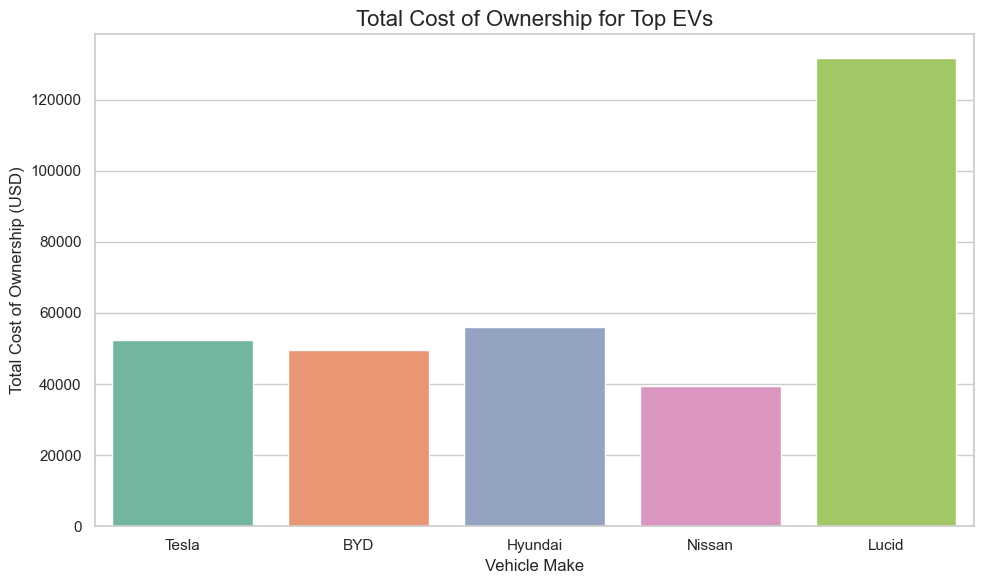

In [617]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming column names are now cleaned up, plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Make', y='Total Cost of Ownership (USD)', data=merged_data, hue='Make', palette='Set2')

# Add labels and title
plt.title('Total Cost of Ownership for Top EVs', fontsize=16)
plt.xlabel('Vehicle Make', fontsize=12)
plt.ylabel('Total Cost of Ownership (USD)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show() 


 ### Energy Cost per Mile Calculation Across Cities

In [611]:
# Calculate the Energy Cost per Year (USD) for each EV
merged_data['Energy Cost per Year (USD)'] = merged_data['Energy Cost per Mile (USD)'] * merged_data['Range (mi)'] * 365

# Calculate the Total Cost of Ownership (USD)
merged_data['Total Cost of Ownership (USD)'] = merged_data['Price (USD)'] + merged_data['Energy Cost per Year (USD)']

# Check the new DataFrame
print(merged_data[['Make', 'Model', 'City', 'Energy Cost per Mile (USD)', 'Energy Cost per Year (USD)', 'Total Cost of Ownership (USD)']])


      Make                   Model    City  Energy Cost per Mile (USD)  \
0    Tesla      Model 3 Long Range  Boston                    0.034358   
1      BYD                  Han EV  Boston                    0.043424   
2  Hyundai  Ioniq 5 Long Range AWD  Boston                    0.041170   
3   Nissan            Leaf SV Plus  Boston                    0.041150   
4    Lucid       Air Grand Touring  Boston                    0.032558   

   Energy Cost per Year (USD)  Total Cost of Ownership (USD)  
0                     4489.50                       52479.50  
1                     4675.65                       49675.65  
2                     4237.65                       56067.65  
3                     3394.50                       39434.50  
4                     6132.00                      131732.00  


### Energy Cost Analysis

In [612]:
# First, sort the dataframe by 'City' and 'Range (mi)' in descending order
merged_data_sorted = merged_data.sort_values(by=['City', 'Range (mi)'], ascending=[True, False])

# Then, for each city, take the top 5 rows
top_5_evs = merged_data_sorted.groupby('City').head(5).reset_index(drop=True)

# Calculate Energy Cost per Mile in USD based on the local electricity rate (CPkpH)
top_5_evs['Energy Cost per Mile Adjusted (USD)'] = top_5_evs['Energy Cost per Mile (USD)'] * top_5_evs['Average Cents per kWh (CPkpH)'] / 100

# Show the top 5 EVs with adjusted energy cost per mile for each city
print(top_5_evs[['Make', 'Model', 'City', 'Range (mi)', 'Energy Cost per Mile (USD)', 'Average Cents per kWh (CPkpH)', 'Energy Cost per Mile Adjusted (USD)']])


      Make                   Model    City  Range (mi)  \
0    Lucid       Air Grand Touring  Boston         516   
1    Tesla      Model 3 Long Range  Boston         358   
2      BYD                  Han EV  Boston         295   
3  Hyundai  Ioniq 5 Long Range AWD  Boston         282   
4   Nissan            Leaf SV Plus  Boston         226   

   Energy Cost per Mile (USD)  Average Cents per kWh (CPkpH)  \
0                    0.032558                           0.15   
1                    0.034358                           0.15   
2                    0.043424                           0.15   
3                    0.041170                           0.15   
4                    0.041150                           0.15   

   Energy Cost per Mile Adjusted (USD)  
0                             0.000049  
1                             0.000052  
2                             0.000065  
3                             0.000062  
4                             0.000062  


### Cost Comparison and Total Cost of Ownership


In [613]:
# Calculate the energy cost per year (assuming 365 days of driving per year and average range)
top_5_evs['Energy Cost per Year (USD)'] = top_5_evs['Energy Cost per Mile Adjusted (USD)'] * top_5_evs['Range (mi)'] * 365

# Now calculate the Total Cost of Ownership (Price + Energy Cost per Year)
top_5_evs['Total Cost of Ownership (USD)'] = top_5_evs['Price (USD)'] + top_5_evs['Energy Cost per Year (USD)']

# Display the top 5 EVs with total cost of ownership for each city
print(top_5_evs[['Make', 'Model', 'City', 'Price (USD)', 'Energy Cost per Year (USD)', 'Total Cost of Ownership (USD)']])


      Make                   Model    City  Price (USD)  \
0    Lucid       Air Grand Touring  Boston       125600   
1    Tesla      Model 3 Long Range  Boston        47990   
2      BYD                  Han EV  Boston        45000   
3  Hyundai  Ioniq 5 Long Range AWD  Boston        51830   
4   Nissan            Leaf SV Plus  Boston        36040   

   Energy Cost per Year (USD)  Total Cost of Ownership (USD)  
0                    9.198000                  125609.198000  
1                    6.734250                   47996.734250  
2                    7.013475                   45007.013475  
3                    6.356475                   51836.356475  
4                    5.091750                   36045.091750  


### Data Visualization

### Bar Chart for Total Cost of Ownership

        City  Total Cost per Year (USD)  Price (USD)  \
3  New Delhi                    1697.60        35000   
0    Beijing                    2017.12        40000   
1     Berlin                    2336.64        45000   
2     Boston                    2656.16        50000   

   Energy Cost per Year (USD)  
3                     1347.60  
0                     1617.12  
1                     1886.64  
2                     2156.16  


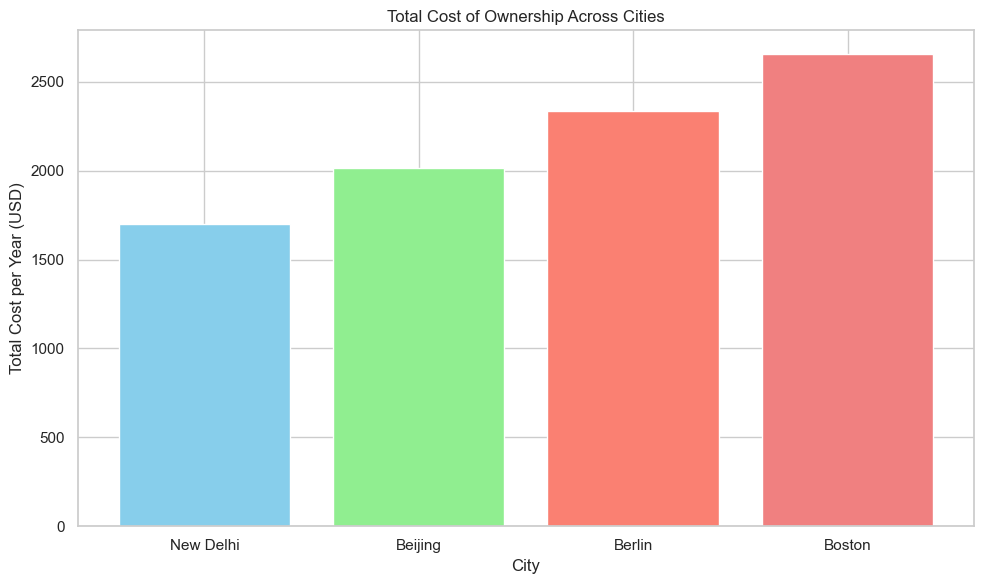

In [614]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumed data for each city
data = {
    'City': ['Beijing', 'Berlin', 'Boston', 'New Delhi'],
    'Price (USD)': [40000, 45000, 50000, 35000],
    'Energy Cost per Mile (USD)': [0.12, 0.14, 0.16, 0.10]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define constants
annual_mileage = 13476  # Average annual mileage in miles
interest_rate = 0.05  # 5% interest rate for financial cost

# Calculate the Financial Cost (5% of the vehicle price)
df['Financial Cost (USD)'] = df['Price (USD)'] * interest_rate

# Calculate the Cost per Year by dividing the financial cost by 5
df['Cost per Year (USD)'] = df['Financial Cost (USD)'] / 5

# Calculate the Energy Cost per Year based on the energy cost per mile and annual mileage
df['Energy Cost per Year (USD)'] = df['Energy Cost per Mile (USD)'] * annual_mileage

# Calculate the Total Cost per Year by adding the cost per year and the energy cost per year
df['Total Cost per Year (USD)'] = df['Cost per Year (USD)'] + df['Energy Cost per Year (USD)']

# Sort the data by Total Cost per Year
df_sorted = df.sort_values(by='Total Cost per Year (USD)')

# Display the results
print(df_sorted[['City', 'Total Cost per Year (USD)', 'Price (USD)', 'Energy Cost per Year (USD)']])

# Plot the Total Cost of Ownership for each city
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['City'], df_sorted['Total Cost per Year (USD)'], color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.title('Total Cost of Ownership Across Cities')
plt.xlabel('City')
plt.ylabel('Total Cost per Year (USD)')
plt.tight_layout()
plt.show()


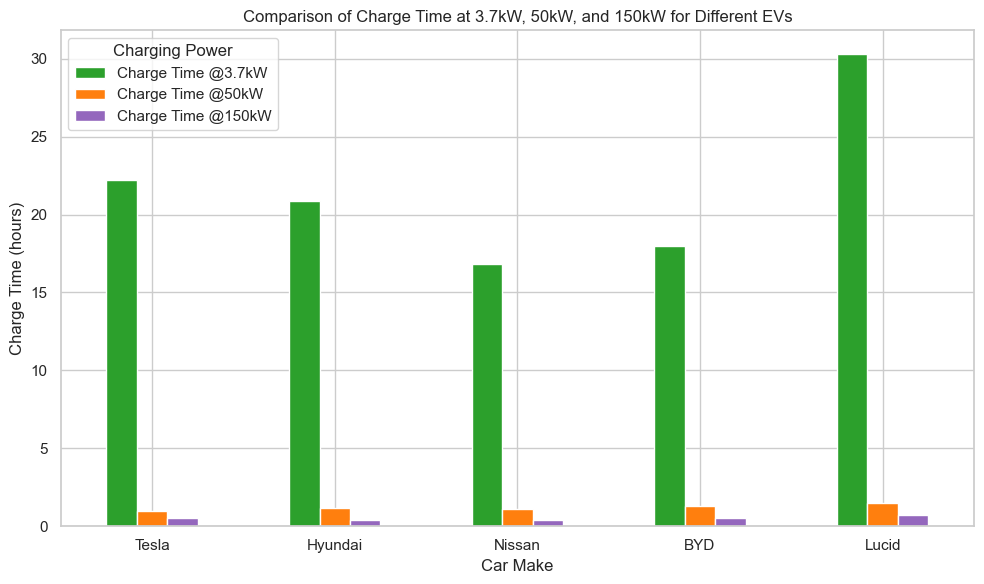

In [621]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data extended with 50kW
data = {
    'Make': ['Tesla', 'Hyundai', 'Nissan', 'BYD', 'Lucid'],
    'Charge Time @3.7kW': ['22.2h', '20.9h', '16.8h', '18.0h', '30.3h'],
    'Charge Time @50kW': ['1.0h', '1.2h', '1.1h', '1.3h', '1.5h'],
    'Charge Time @150kW': ['0.5h', '0.4h', '0.4h', '0.5h', '0.7h']
}

# Convert to DataFrame
merged_df_extended = pd.DataFrame(data)

# Clean and convert charging time columns to numeric
for col in ['Charge Time @3.7kW', 'Charge Time @50kW', 'Charge Time @150kW']:
    merged_df_extended[col] = merged_df_extended[col].str.replace('h', '').astype(float)

# Prepare data for plotting
charge_time_data = merged_df_extended.set_index('Make')[['Charge Time @3.7kW', 'Charge Time @50kW', 'Charge Time @150kW']]

# Plot grouped bar chart
charge_time_data.plot(kind='bar', figsize=(10, 6), color=['#2ca02c', '#ff7f0e', '#9467bd'])

# Add labels and title
plt.xlabel('Car Make')
plt.ylabel('Charge Time (hours)')
plt.title('Comparison of Charge Time at 3.7kW, 50kW, and 150kW for Different EVs')
plt.xticks(rotation=0)
plt.legend(title='Charging Power')
plt.tight_layout()
plt.show()


Top 5 Most Efficient EVs (by mi/kWh):
      Make                   Model  mi/kWh  Range (mi)  Battery Size (kWh)  \
4    Lucid       Air Grand Touring    4.61         516               112.0   
0    Tesla      Model 3 Long Range    4.37         358                82.0   
3   Nissan            Leaf SV Plus    3.65         226                62.0   
2  Hyundai  Ioniq 5 Long Range AWD    3.64         282                77.4   
1      BYD                  Han EV    3.45         295                85.4   

   Price (USD)  
4       125600  
0        47990  
3        36040  
2        51830  
1        45000  


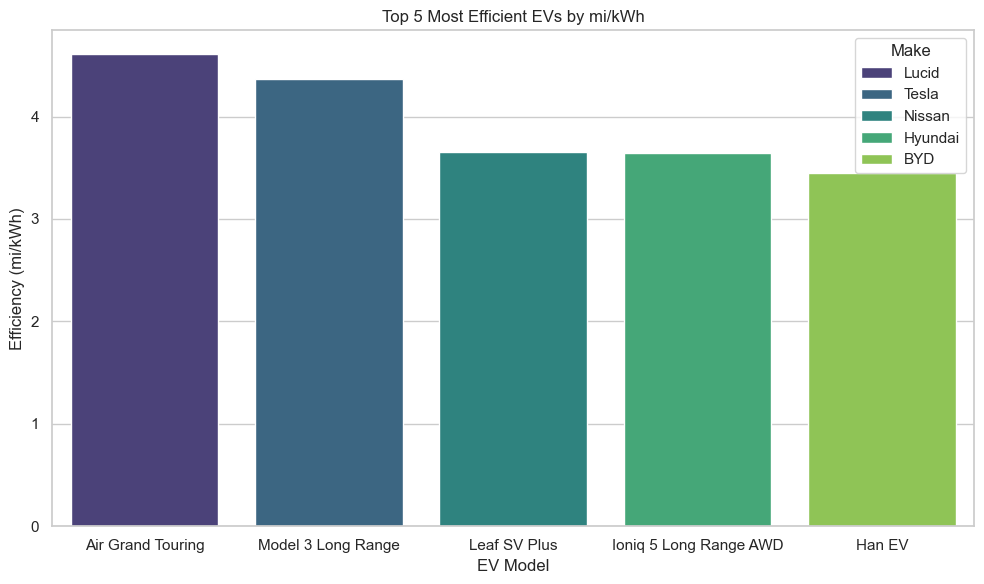

In [622]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded and preprocessed the dataset as `ev_data`

# Step 1: Drop rows with missing efficiency values (if any)
ev_efficiency_data = ev_data.dropna(subset=['mi/kWh'])

# Step 2: Sort EVs by efficiency (mi/kWh) in descending order
top_5_efficient_evs = ev_efficiency_data.sort_values(by='mi/kWh', ascending=False).head(5)

# Step 3: Display the top 5 efficient EVs
print("Top 5 Most Efficient EVs (by mi/kWh):")
print(top_5_efficient_evs[['Make', 'Model', 'mi/kWh', 'Range (mi)', 'Battery Size (kWh)', 'Price (USD)']])

# Step 4: Plot bar chart for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='mi/kWh', hue='Make', data=top_5_efficient_evs, palette='viridis')
plt.title('Top 5 Most Efficient EVs by mi/kWh')
plt.ylabel('Efficiency (mi/kWh)')
plt.xlabel('EV Model')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Conclusion
The analysis showed that EV efficiency varies significantly across manufacturers. 
Weight negatively impacts energy efficiency, while higher battery capacity boosts range. 
Energy cost per mile also varies across cities, making some EVs more affordable depending on local electricity rates. 
Tesla and Lucid consistently ranked among the most efficient EV manufacturers.